Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Oleg Bushtyrkov | k12338089 | 13.05.2024, 10:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &ndash; Introduction to Reinforcement Learning (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, M. Abbass, A. Schörgenhumer<br>
<b>Date:</b> 07-05-2024

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

In [3]:
!pip install gymnasium
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time
import gymnasium as gym

from IPython import display
from typing import Tuple

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

# Check minimum versions.
u4.check_module_versions()

Defaulting to user installation because normal site-packages is not writeable


/home/olegbushtyrkov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Installed Python version: 3.10 (✓)
Installed numpy version: 1.26.4 (✓)
Installed pandas version: 2.2.1 (✓)
Installed PyTorch version: 2.1.1+cu121 (✓)
Installed matplotlib version: 3.8.3 (✓)
Installed seaborn version: 0.13.0 (✓)
Installed gym version: 0.29.1 (✓)


<h2>Dissection of an Environment</h2>
<p>All exercises in this assignment are referring to the <i>FrozenLake</i> environment as described <a href="https://gymnasium.farama.org/environments/toy_text/frozen_lake/">here</a>.
<center>
    <cite>Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly <span style="color:rgb(0,255,0)">frozen</span>, but there are a few <span style="color:rgb(255,0,0)">holes</span> where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the <span style="color:rgb(255,0,255)">disc</span>. However, the ice is slippery, so you won't always move in the direction you intend.</cite>
    </center></p>


<p>There are <i>four</i> types of surfaces described in this environment:
<ul>
    <li><code>S</code> $\rightarrow$ starting point (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>F</code> $\rightarrow$ frozen surface (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>H</code> $\rightarrow$ hole (<span style="color:rgb(255,0,0)"><i>fall to your doom</i></span>)</li>
    <li><code>G</code> $\rightarrow$ goal (<span style="color:rgb(255,0,255)"><i>frisbee location</i></span>)</li>
</ul>

In [4]:
# Utility function for creating a default FrozenLake environment.
def FrozenLakeEnv(slippery: bool = False, max_episode_steps: int = 100_000) -> gym.Env:
    return gym.make('FrozenLake-v1', desc=None, map_name='8x8', is_slippery=slippery, max_episode_steps=max_episode_steps, render_mode='ansi')

<div class="alert alert-warning">
    <b>Exercise 1. [10 Points]</b>
    <ul>
        <li>Create a <code>FrozenLakeEnv</code> with <code>slippery = False</code> and set the seed to $42$. Use this environment in the subsequent tasks if not specified otherwise.</li>
        <li>Gather and print the amount of different <i>actions</i> as well as <i>states</i> of the <code>FrozenLakeEnv</code> instance. Discuss the results.</li>
        <li>Display the <i>reward table entry</i> for the current state. Discuss the different elements of the resulting dictionary.</li>
        <li>Perform $15$ different random actions using <code>env_lake.action_space.sample()</code>. Print the action number, state (observation), reward, whether the episode is done (either by being terminated or being truncted), and render the corresponding environment. Hint: If the episode is done, reset the environment or you are stuck.</li>
    </ul>
</div>

In [5]:
# your code/answer goes here
frozen_lake = FrozenLakeEnv()
u4.set_environment_seed(frozen_lake, 42)
print(frozen_lake.render())
num_actions = frozen_lake.action_space.n
num_states = frozen_lake.observation_space.n
print(f'The FrozenLakeEnv has {num_actions} actions and {num_states} states.')


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

The FrozenLakeEnv has 4 actions and 64 states.


The actions of the environment are; moving left, right, up, or down.  
While the states relate to the total number of surfaces in the env.

In [6]:
current_state_id = frozen_lake.s
frozen_lake.P[current_state_id]

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


{0: [(1.0, 0, 0.0, False)],
 1: [(1.0, 8, 0.0, False)],
 2: [(1.0, 1, 0.0, False)],
 3: [(1.0, 0, 0.0, False)]}

Each state has a an equal chance of occuring (1.0 by default).  
For both action 0 and 3, the next state is '0' (whatever that may be), while action 1 is followed by state '8', and action 2 by state '1'.  
No action has a reward associated with it. So it would seem that the maximum number of points, is the same as the minimum, which is '0'.  
No action finishes the episode.

In [7]:
reward_dict = frozen_lake.P[frozen_lake.s]
for i in range(15):
    action = frozen_lake.action_space.sample()
    print(frozen_lake.step(action))
    print(frozen_lake.render())
    _, _, terminated, truncated, _ = frozen_lake.step(action)
    if terminated == True or truncated == True:
        frozen_lake.reset(seed=42)

(0, 0.0, False, False, {'prob': 1.0})
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(0, 0.0, False, False, {'prob': 1.0})
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(1, 0.0, False, False, {'prob': 1.0})
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(10, 0.0, False, False, {'prob': 1.0})
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(26, 0.0, False, False, {'prob': 1.0})
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(26, 0.0, False, False, {'prob': 1.0})
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(17, 0.0, False, False, {'prob': 1.0})
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(17, 0.0, False, False, {'prob': 1.0})
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

(17, 0.0, False, False, {'prob': 1.0}

<h2>Tackling the Environment with Random Exploration</h2>
<p>In the exercise, we talked about solving this kind of tasks in a na&#xEF;ve way by simply applying <i>brute force</i>: using <i>random search</i>. So far, we analyzed the <i>action</i> as well as the <i>state space</i> and came to the conclusion that such an approach is feasible. Here is the outline of such an approach:
<ul>
    <li><code>I</code> $\rightarrow$ choose a random <i>action</i> with respect to the <i>current</i> state.</li>
    <li><code>II</code> $\rightarrow$ execute previously chosen <i>action</i> and transition into a <i>new</i> state.</li>
    <li><code>III</code> $\rightarrow$ if the episode is finished but the goal is not reached, <i>reset</i> the <i>environment</i>.</li>
</ul>

This procedure is repeated as long as the task is not solved or a defined <i>maximum number of steps</i> is reached, whatever triggers first (<code>IV</code>). Adapt the function <code>apply_random_search</code> as discussed during the exercise. Mark the corresponding sections of the code using <code>I</code>, <code>II</code>, <code>III</code> and <code>IV</code>. Note that our <i>random search</i> is <i>not</i> guaranteed to find  the solution of a task in <i>finite time</i>, hence an upper bound on the <i>runtime</i> is often applied as a safety net (in our case the <i>maximum number of steps</i>).</p>

<div class="alert alert-warning">
    <b>Exercise 2.1 [10 Points]</b>
    <ul>
        <li>Implement the <i>random search</i> algorithm as outlined above (equivalently to the one discussed during the exercise).</li>
        <li>Apply your random search implementation on a freshly $42$-seeded <code>FrozenLakeEnv</code> instance, with an animation delay of $0.03$ and a maximum number of steps of $999$.</li>
        <li>Was the goal reached, how many steps were taken and how often did an involuntary dive happen?</li>
        <li>Repeat the experiment and find parameters (random seed, maximum number of steps) that lead to a successful run (you do not need to animate this second experiment).</li>
    </ul>
</div>

In [8]:
# your code/answer goes here
def apply_random_search(environment: gym.Env, max_steps: int, animate: bool = False,
                        delay: float = 0.01) -> Tuple[int, int, int]:
    """
    Solve specified environment by applying random search.
    
    :param environment: the environment on which to apply random search
    :param animate: animate the random search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """
    num_steps, num_penalties, final_reward = 0, 0, 0
    
    # <IV>: repeat random search procedure as long as the episode is still ongoing.
    done = False
    while not done:

        # <III>: if the episode is finished but the goal is not reached, reset the environment.
        if num_steps == max_steps and done == False:
            frozen_lake.reset(seed=42)
        
        # <I>: choose a random action with respect to the current state.
        current_action = environment.action_space.sample()
        
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, terminated, truncated, _ = environment.step(current_action)
        done = terminated or truncated
        
        # Update counter for inflicted penalties.
        final_reward += current_reward
        if current_reward == -10:
            num_penalties += 1
        num_steps += 1
        
        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render())
            print(f'Step No.: {num_steps}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nReward: {current_reward}')
            time.sleep(delay)
    
    return num_steps, num_penalties, final_reward

frozen_lake2 = FrozenLakeEnv()
u4.set_environment_seed(frozen_lake2, 42)
apply_random_search(environment=frozen_lake2, max_steps=999, animate=True, delay=0.03)

  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 23
State ID: 19
Action ID: 0
Reward: 0.0


(23, 0, 0.0)

Steps: 23  
Falls: 1  
Goal reached: No

In [9]:
frozen_lake2 = FrozenLakeEnv()
for i in range(10, 200):
    u4.set_environment_seed(frozen_lake2, i)
    result = apply_random_search(environment=frozen_lake2, max_steps=999, animate=False, delay=0.03)
    if result[-1] > 0:
        print(result, f"occured at Seed: {i}, max_steps: 999")
        break

(60, 0, 1.0) occured at Seed: 135, max_steps: 999


<p>To drill down on the drawbacks of plain <i>random search</i>, we are designing the following experimental setup (<i>Hint</i>: it is actually the same experimental setup as already discussed during the exercise, so you might orient yourself on the implementation presented during class):
<ul>
    <li>Repeat the previous <i>random search</i> procedure a specified amount of times.</li>
    <li>Aggregate the results of each run for later analysis.</li>
    <li>Visualize the aggregated results using <i>box-</i> and <i>strip-plots</i> (or <i>swarm-plots</i>).</li>
</ul>
Once again, we are setting the <i>random seed</i>, but take care of setting it <i>outside</i> the loop, otherwise the same result is reported with each iteration (and an aggregation of the results would not give us any more insights).</p>

<div class="alert alert-warning">
    <b>Exercise 2.2 [10 Points]</b>
    <ul>
        <li>Conduct a <i>random search experiment</i> as outlined above, using $100$ repetitions and the random seed set to $42$. Set the maximum number of steps to $10,000$.</li>
        <li>Create a plot showing the results and interpret the visualization.</li>
        <li>In comparison with the <code>Taxi</code> environment, what might be the problem with <code>FrozenLakeEnv</code> w.r.t. random exploration?</li>
    </ul>
</div>

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: Se

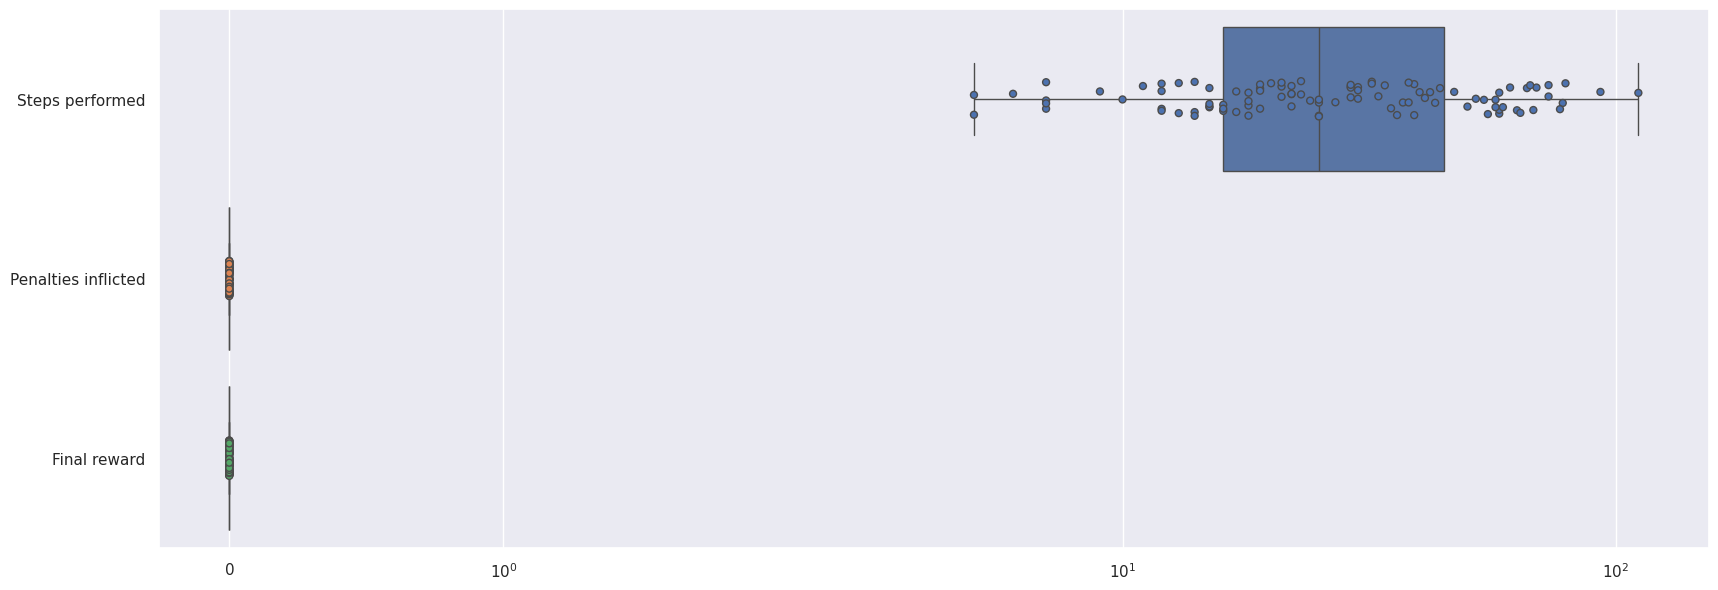

In [10]:
# your code/answer goes here
frozen_lake3 = FrozenLakeEnv()
u4.set_environment_seed(environment=frozen_lake3, seed=42)
num_steps_total, num_penalties_total, final_reward_total = [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    frozen_lake3.reset()
    num_steps, num_penalties, final_reward = apply_random_search(environment=frozen_lake3, max_steps=10000)
    num_steps_total.append(num_steps)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total
})

# Visualize aggregated results of the random search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
plt.show()

Since no action imposes a penalty to the overall score, it neing at '0' doesn't raise any concern.  
Though most of the 'Final reward' values are likely '0', some of them are bound to be '1'. However, due to the x-axis being scaled logarithmically, its difficult to discern '0's from '1's.

The FrozenLakeEnv() is interupted anytime the 'traveller' (so to say) walks over a hole ('H'). So many iterations are prematurely ended.  
The environment is also very strict with regards to points, and their removal. You either finish with '1', or you're stuck at '0'.

<h2>Tackling the Environment with $Q$-Learning</h2>
<p>In a simplified version of $Q$-learning, the <b>$\boldsymbol{Q}$-value</b>
\begin{equation}
    Q(s,a)
\end{equation}</p>

<p>is the expected future reward of being in state $s$ and taking action $a$. Intuitively, if the $Q$-values are learned correctly, a good policy would be to take the action which maximizes the expected future reward. This is what $Q$-learning is doing. $Q$-learning lets the agent <b>use the environment's rewards to learn</b>, over time, the best action to take in a given state. $Q$-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the $Q$-values are updated using the equation:
\begin{equation}
    Q(s_t,a_t) \leftarrow (1 - \alpha) \cdot Q(s_t,a_t) + \alpha \cdot \left( r_t + \gamma \max_{a_{t+1}} Q(s_{t+1}, a_{t+1})\right)
\end{equation}</p>

<p>We are assigning $\leftarrow$, or updating, the $Q$-value of the agent's current state and action, denoted as $Q(s_t,a_t)$ with $\alpha$ as the learning rate, i.e the extent to which our $Q$-values are being updated in every iteration.</p>

<p>The <b>$\boldsymbol{Q}$-table</b> is a matrix where we have a row for every state and a column for every action: $64$ and $4$, respectively, when referring to the current <i>FrozenLake</i> example. It's first initialized to $0$, and then values are updated during training.</p>

<p>Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i> using <i>random search</i>. This time, we want to apply a more sophisticated algorithm, namely $Q$-learning:
<ul>
    <li><code>I</code> $\rightarrow$ Choose action $a_t$.
    <li><code>II</code> $\rightarrow$ Go from state $s_t$ to state $s_{t+1}$ by taking action $a_{t}$.
    <li><code>III</code> $\rightarrow$ For all possible $Q$-values from the state $s_{t+1}$, select the highest.
    <li><code>IV</code> $\rightarrow$ Update $Q$-table values using the equation from above.
    <li><code>V</code> $\rightarrow$ Set the next state as the current state and go back to <code>I</code> until a final state is reached (end of episode).
</ul>

This procedure is repeated for as many episodes as specified (<code>VI</code>).</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [11]:
def visualize_q_table(q_table: np.ndarray, title: str = '') -> None:
    """
    Visualize Q-table using a heatmap plot.
    
    :param q_table: Q-table to visualize
    """
    fig, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(data=q_table, ax=ax)
    ax.set(xlabel='Action', ylabel='State', title=title)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig=fig)


def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state, _ = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            action = np.argmax(q_table[state])
            
            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

<div class="alert alert-warning">
    <b>Exercise 3.1 [10 Points]</b>
    <ul>
        <li>Implement <i>$Q$-learning</i> as outlined above (equivalently to the one discussed during the exercise).</li>
        <li>Apply $Q$-learning on a freshly $42$-seeded <code>FrozenLakeEnv</code> instance for $590$ episodes, with $10$ delay steps, a discount factor $\gamma=0.99$ and $\alpha=0.15$. Important: Make sure that you create a new <code>FrozenLakeEnv</code> instance where <code>max_episode_steps</code> is set to $100$ (only in this exercise), since otherwise, the code execution might take very long.</li>
        <li>Interpret the visualization of the resulting $Q$-table. What do you observe? Why do you observe this effect?</li>
    </ul>
</div>

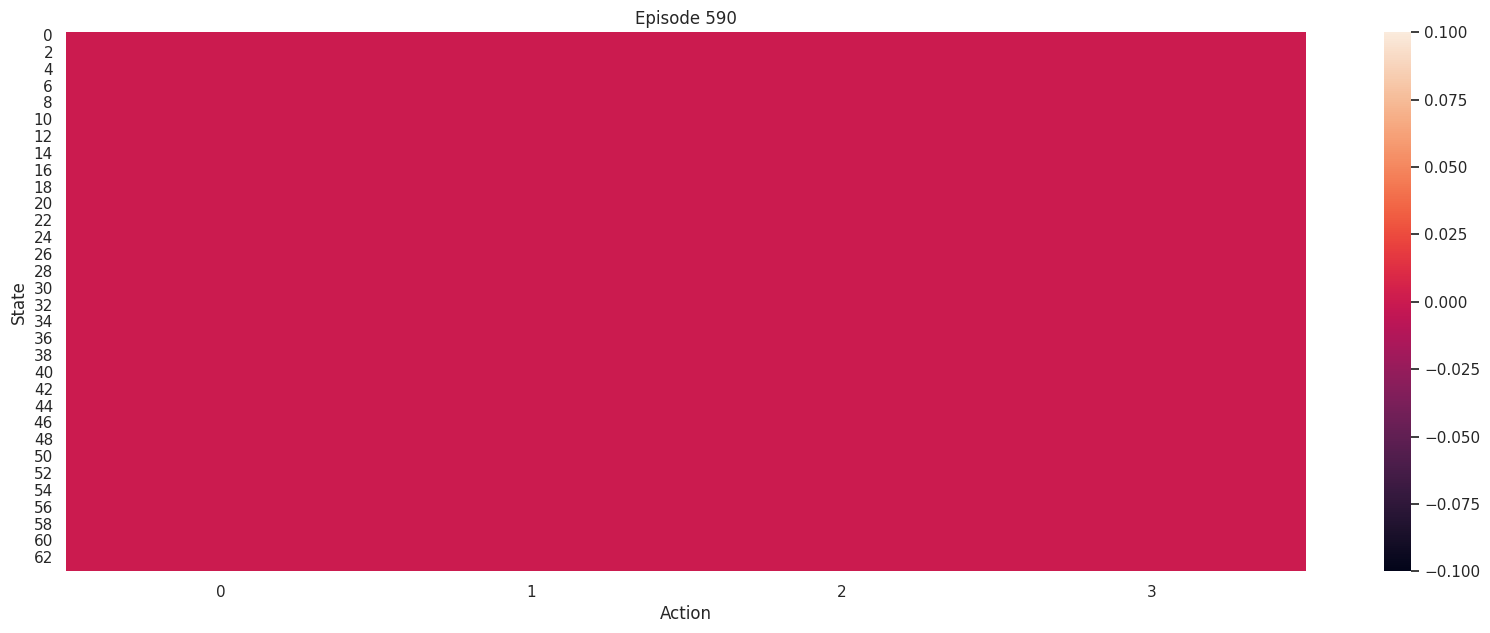

In [12]:
# your code/answer goes here
def visualize_q_table(q_table: np.ndarray, title: str = '') -> None:
    """
    Visualize Q-table using a heatmap plot.
    
    :param q_table: Q-table to visualize
    """
    fig, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(data=q_table, ax=ax)
    ax.set(xlabel='Action', ylabel='State', title=title)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig=fig)


def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state, _ = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            action = np.argmax(q_table[state])
            
            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table
    
frozen_lake4 = FrozenLakeEnv(max_episode_steps=100)
u4.set_environment_seed(environment=frozen_lake4, seed=42)
q_table = apply_q_learning(
    environment=frozen_lake4,
    num_episodes=590,
    alpha=0.15,
    gamma=0.99,
    animate=True,
    delay_steps=10
)

We can observe that every action has the same 'Q-value' at every state. This means that any action, at any state, results in the same expected reward (0).

<p>Very likely, the $Q$-table of the previous experiment looked a little bit odd. Try to add exploration to your algorithm by adapting your $Q$-learning implementation:
    <ul>
        <li>Get a random uniform number between $0$ and $1$.</li>
        <li>If the number is $< 0.1$, choose your action as usual (according to current Q-table).</li>
        <li>Otherwise, sample a random action.</li>
    </ul>
</p>

<div class="alert alert-warning">
    <b>Exercise 3.2 [20 Points]</b>
    <ul>
        <li>Modify the <i>$Q$-learning</i> implementation from the previous tasks as outlined above (mark the corresponding code sections).</li>
        <li>Apply $Q$-learning on a freshly $42$-seeded <code>FrozenLakeEnv</code> instance for $50,000$ episodes, with $1,000$ delay steps, discount factor $\gamma=0.99$ and $\alpha=0.15$.</li>
        <li>Interpret the visualization of the resulting $Q$-table. What do you observe (compare with the previous visualization)?</li>
        <li>Use this $Q$-learning strategy to also tackle the <code>FrozenLakeEnv</code> with <code>slippery = True</code>. Compare both $Q$-tables and discuss the differences.</li>
    </ul>
</div>

In [13]:
def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    # your code goes here
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state, _ = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            random_number = np.random.uniform(0,1)
            if random_number < 0.1:
                action = np.argmax(q_table[state])
            else: 
                action = np.random.randint(0,4)
            
            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

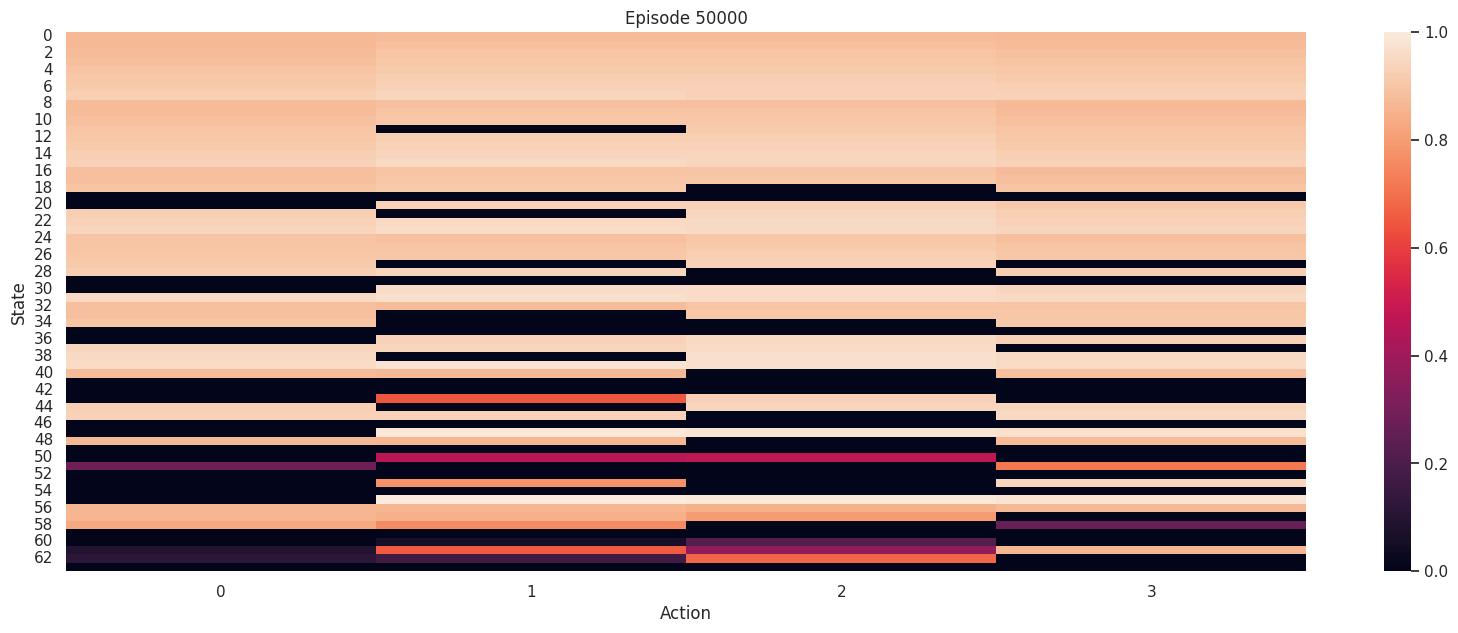

In [14]:
# your code/answer goes here
frozen_lake4 = FrozenLakeEnv()
u4.set_environment_seed(environment=frozen_lake4, seed=42)
q_table = apply_q_learning(
    environment=frozen_lake4,
    num_episodes=50000,
    alpha=0.15,
    gamma=0.99,
    animate=True,
    delay_steps=1000
)

We can now see that there are differences between expected rewards at some of the states. This means that some actions are considered to be more/less valuable than others.

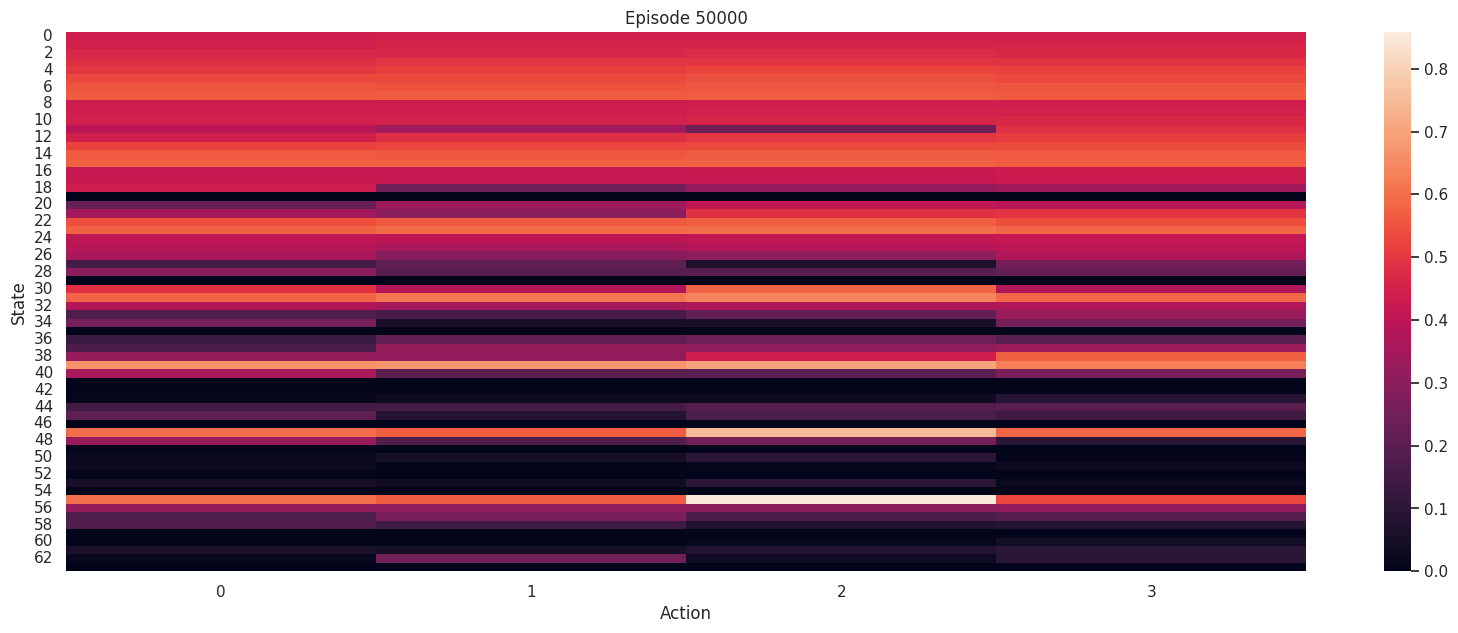

In [15]:
frozen_lake4 = FrozenLakeEnv(slippery=True)
u4.set_environment_seed(environment=frozen_lake4, seed=42)
q_table = apply_q_learning(
    environment=frozen_lake4,
    num_episodes=50000,
    alpha=0.15,
    gamma=0.99,
    animate=True,
    delay_steps=1000
)

The expected rewards for any action is lower on average, this time.  
Previously, there were a lot of 1.0 rewards handed-out, however in the slippery environment, there are way fewer '1.0's awarded.  
However the structure of the q-table is relatively the same, with rewards being abundant at the start, and dwindiling the more states we go through.

<div class="alert alert-warning">
    <b>Exercise 3.3 [15 Points]</b>
    <ul>
        <li>Implement a function for applying a pre-trained $Q$-table on a <code>FrozenLakeEnv</code> instance (like discussed during class).</li>
        <li>For both <code>FrozenLakeEnv</code> instances (with <code>slippery = False</code> and <code>slippery = True</code>), conduct a guided search using the corresponding $Q$-table on a freshly $42$-seeded instance, with an animation delay of $0.1$.</li>
        <li>Answer the following question for both settings: How many steps are necessary to reach the goal at least once and how often did an involuntary dive happen?</li>
        <li>Compare the corresponding policies of each $Q$-table. Which property of the environment is exploited in the slippery policy to avoid involuntary dives?</li>
    </ul>
</div>

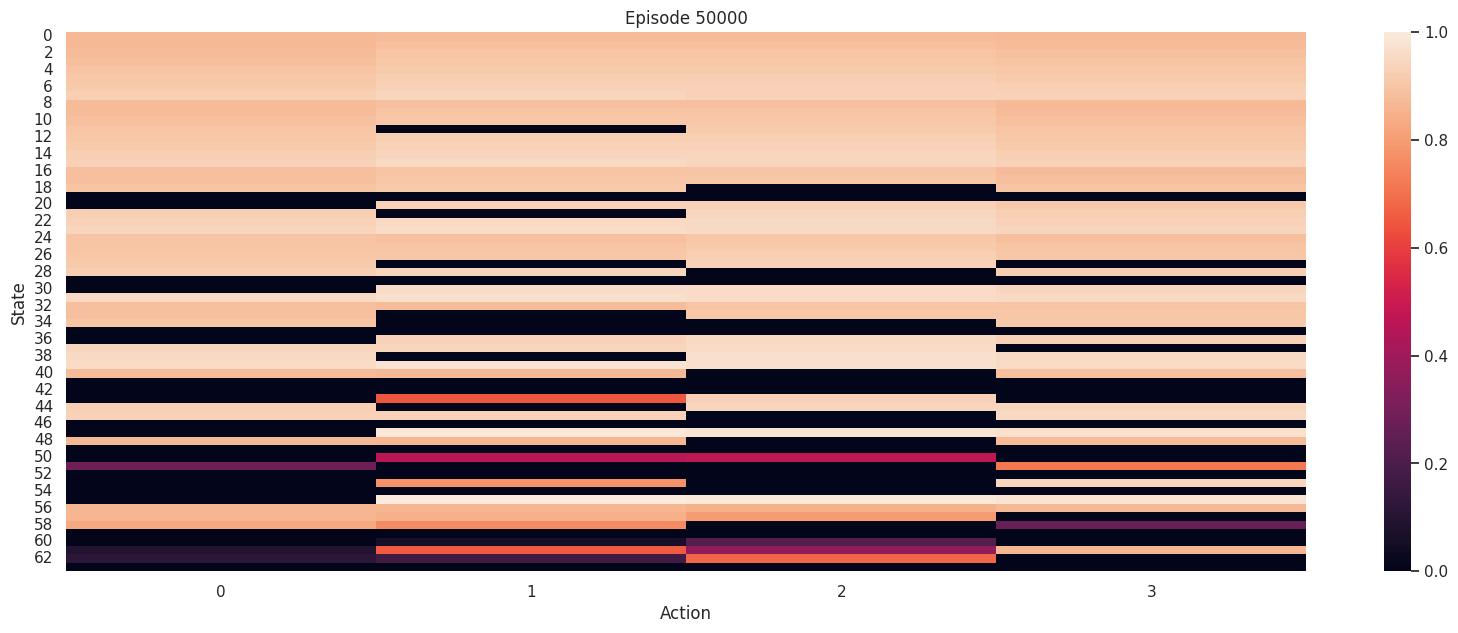

In [16]:
# your code/answer goes here
def apply_q_table(environment: gym.Env, q_table: np.ndarray, animate: bool = False,
                  delay: float = 0.01) -> Tuple[int, int, int]:
    """
    Solve specified environment by applying specified Q-table.
    
    :param environment: the environment on which to apply Q-table guided search
    :param q_table: the Q-table used during Q-table guided search
    :param animate: animate the Q-table guided search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """
    num_steps, num_penalties, final_reward = 0, 0, 0
    
    # <III>: repeat Q-table guided search procedure as long as the episode is still ongoing.
    done = False
    while not done:
        
        # <I>: choose action according to the Q-table with respect to the current state.
        current_action = np.argmax(q_table[environment.s])
        
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, terminated, truncated, _ = environment.step(current_action)
        done = terminated or truncated
        
        # Update counter for inflicted penalties.
        final_reward += current_reward
        if current_reward == -10:
            num_penalties += 1
        num_steps += 1
        
        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render())
            print(f'Step No.: {num_steps}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nReward: {current_reward}')
            time.sleep(delay)
    
    return num_steps, num_penalties, final_reward

frozen_lake6 = FrozenLakeEnv()
u4.set_environment_seed(environment=frozen_lake6, seed=42)
q_table = apply_q_learning(
    environment=frozen_lake6,
    num_episodes=50000,
    alpha=0.15,
    gamma=0.99,
    animate=True,
    delay_steps=1000
)

In [24]:
frozen_lake7 = FrozenLakeEnv(slippery=False)
env_list = [frozen_lake7, frozen_lake8]
for i in env_list:
    u4.set_environment_seed(environment=i, seed=42)
    num_steps, num_penalties, final_reward = apply_q_table(
        environment=i,
        q_table=q_table,
        animate=True,
        delay=0.1
    )

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 11
State ID: 19
Action ID: 1
Reward: 0.0


In [25]:
frozen_lake8 = FrozenLakeEnv(slippery=True)
env_list = [frozen_lake7, frozen_lake8]
for i in env_list:
    u4.set_environment_seed(environment=i, seed=42)
    num_steps, num_penalties, final_reward = apply_q_table(
        environment=i,
        q_table=q_table,
        animate=True,
        delay=0.1
    )

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 11
State ID: 19
Action ID: 1
Reward: 0.0


In both scenarios, it took 14 steps to reach the goal, and there was 1 involuntary dive in both cases.  
In the slippery environment, the equal chances of continuing in the same direction or moving perpendicular, was exploited to reduce the likelyhood of backtracking across the frozen lake.

<div class="alert alert-warning">
    <b>Exercise 3.4 [10 Points]</b>
    <ul>
        <li>Conduct a <i>$Q$-table guided search experiment</i> on the non-slippery environment, as outlined previously, using $100$ repetitions and the random seed set to $42$.</li>
        <li>Create a plot showing the results and interpret the visualization.</li>
        <li>In comparison with the <i>random search</i> experiment, how does the $Q$-table guided search perform? Discuss the results.</li>
    </ul>
</div>

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: Se

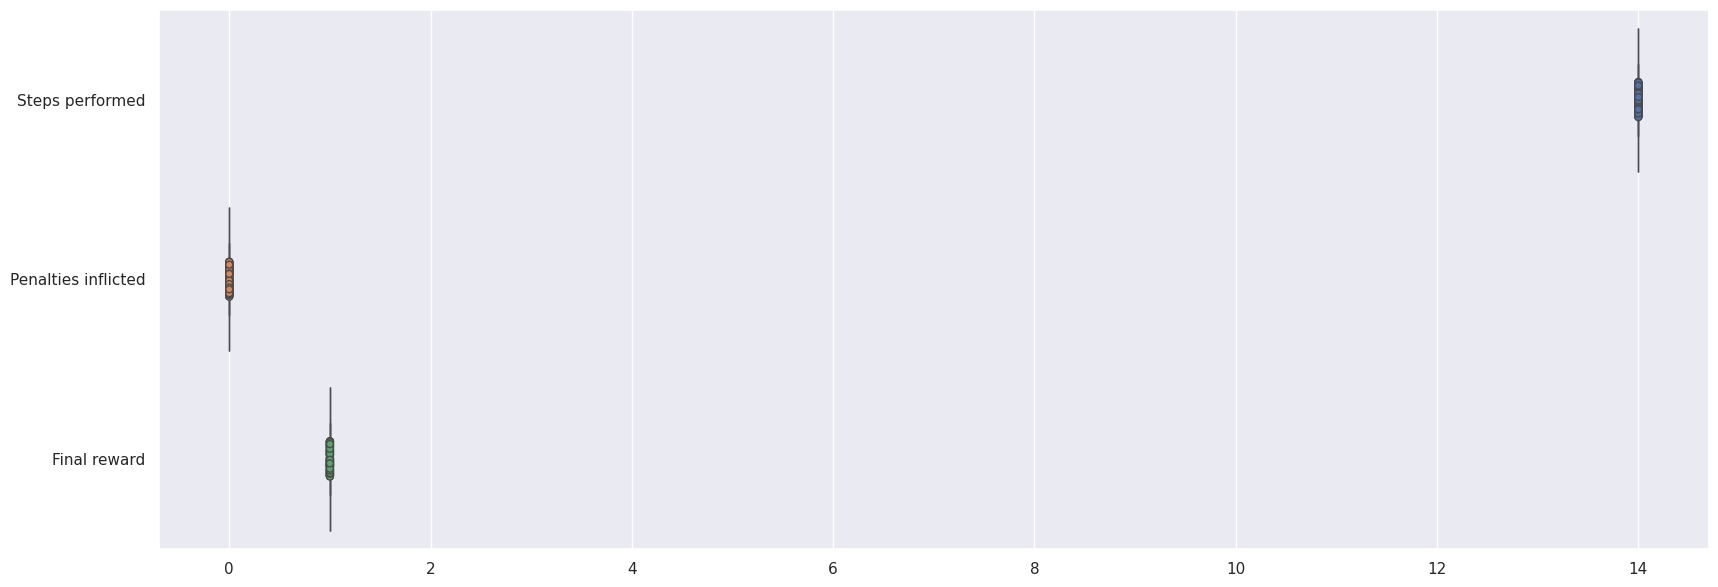

In [26]:
# your code/answer goes here
u4.set_environment_seed(environment=frozen_lake7, seed=42)
num_steps_total, num_penalties_total, final_reward_total = [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    frozen_lake7.reset()
    num_steps, num_penalties, final_reward = apply_q_table(environment=frozen_lake7, q_table=q_table)
    num_steps_total.append(num_steps)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total
})

# Visualize aggregated results of the Q-table guided search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
plt.show()

The magnitude of the 'steps performed' is reduced to '10^1'. The guided search performs a lot better than random search, as instead of taking around 100 steps to reach the goal, it now only takes 14.  
The penalities and rewards are now more distinguishable as well, with every repetition's penalty being '0', and final reward being '1'.

<div class="alert alert-warning">
    <b>Exercise 3.5 [10 Points]</b>
    <ul>
        <li>Repeat the <i>$Q$-table guided search experiment</i> using $100$ repetitions and the random seed set to $42$. This time we would like to compare both policies (learned for the slippery and non-slippery environment) on the slippery environment. Hence, you have to apply the non-slippery $Q$-table to the slippery environment and also the slippery $Q$-table to the same environment. Remember to reset the seed.</li>
        <li>Compare the number of performed steps as well as the performed dives for both policy results using appropirate visualizations (e.g., box and strip plots). Discuss your observations.</li>
    </ul>
</div>

In [28]:
# your code/answer goes here
frozen_lake10 = FrozenLakeEnv(slippery=False)
u4.set_environment_seed(environment=frozen_lake10, seed=42)
q_table1 = apply_q_learning(
    environment=frozen_lake10,
    num_episodes=50000,
    alpha=0.15,
    gamma=0.99,
    animate=False,
    delay_steps=1000
)

frozen_lake11 = FrozenLakeEnv(slippery=True)
u4.set_environment_seed(environment=frozen_lake11, seed=42)
q_table2 = apply_q_learning(
    environment=frozen_lake11,
    num_episodes=50000,
    alpha=0.15,
    gamma=0.99,
    animate=False,
    delay_steps=1000
)


/home/olegbushtyrkov/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948

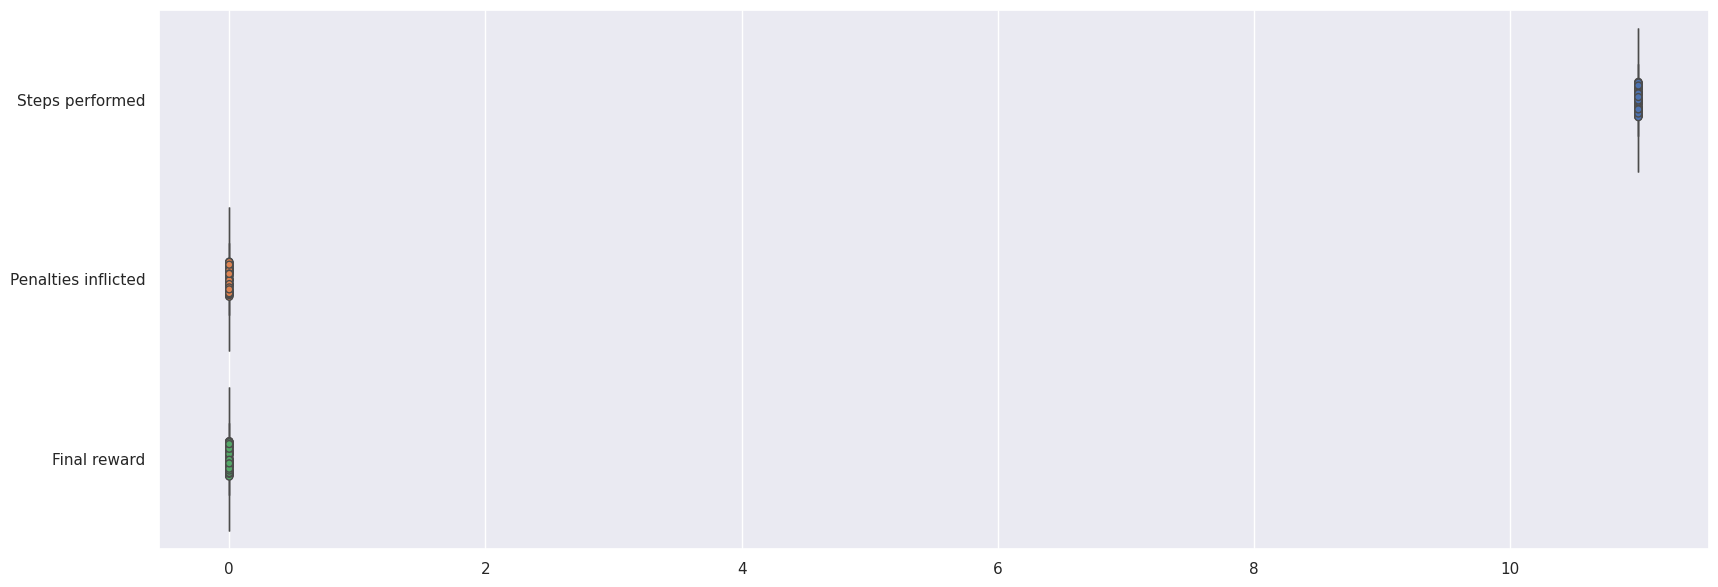

/home/olegbushtyrkov/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/olegbushtyrkov/.local/lib/python3.10/site-packages/seaborn/_base.py:948

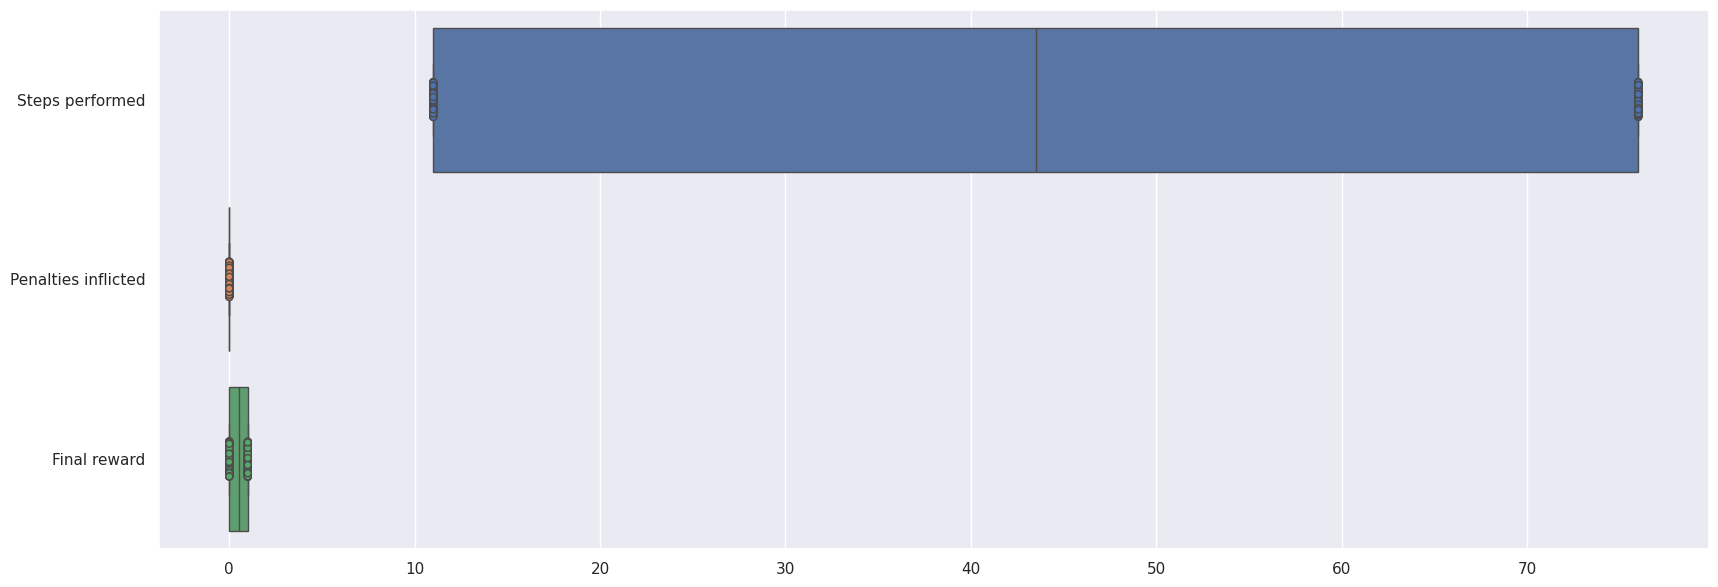

In [32]:
frozen_lake12 = FrozenLakeEnv(slippery=True)
u4.set_environment_seed(environment=frozen_lake12, seed=42)
num_steps_total, num_penalties_total, final_reward_total = [], [], []
num_repetitions = 100

for i in [q_table1, q_table2]:
    # Collect information over multiple repetitions.
    for repetition in range(num_repetitions):
        frozen_lake12.reset()
        u4.set_environment_seed(environment=frozen_lake12, seed=42)
        num_steps, num_penalties, final_reward = apply_q_table(environment=frozen_lake12, q_table=i)
        num_steps_total.append(num_steps)
        num_penalties_total.append(num_penalties)
        final_reward_total.append(final_reward)
    
    # Combine collected information to a data frame for further downstream analysis.
    collected_experiment_info = pd.DataFrame({
        'Steps performed': num_steps_total,
        'Penalties inflicted': num_penalties_total,
        'Final reward': final_reward_total
    })
    
    # Visualize aggregated results of the Q-table guided search procedure.
    fig, ax = plt.subplots(figsize=(20, 7))
    sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
    sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
    plt.show()

For the non-slippery q-table, the slippery model performed around 14 steps before reaching the goal. There were also no unintentional dives performed.  
The slippery q-table resulted in a lot more steps needed to be taken to reach the goal (~11-76 steps), with a large number of repititions resulting in dives.

<div class="alert alert-warning">
    <b>Exercise 3.6 [5 Points]</b>
    <ul>
        <li>Assume that you are given new non-slippery <i>FrozenLake</i> environments where holes and frozen tiles are completely randomized (the grid size, start and goal position are the same). How would your learned non-slippery policy from above perform?</li>
    </ul>
</div>

I think it would perform just as well as the 'random search' method, as its learned information will be of little help when it doesn't 'know' which tiles are holes, and which are frozen.